# Emissions Intensity Clustering

The goal of this script is to determine which plants have increased emissions intensity, which have decreased, why the emissions intensity has changed, and by how much. We start by plotting the data, and looking at various aggregations.

In [2]:
import numpy as np
import pandas as pd  # Note: need v 0.24.1
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
sns.set()
sns.set_context("talk", rc={"font.size":16,"axes.titlesize":24,"axes.labelsize":20,"axes.suptitlesize":30})

In [3]:
EI = pd.read_csv('emissionsIntensity.csv')
print(EI.shape[0]/3)
EI.head()

725.0


,ORISPL_CODE,UNITID,NAME,FUEL,GAS,2001,2002,2003,2004,2005,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,87,1,Escalante,coal,CO2,1.140423,0.995313,0.917968,0.989163,1.009391,...,1.105578,1.139843,1.177716,1.144533,1.105952,1.050198,0.996492,1.036716,1.056700,1.062672
1,87,1,Escalante,coal,SO2,1.554520,1.348214,1.188432,1.276701,1.268912,...,1.336621,1.356052,1.428336,1.305897,1.169239,0.980457,1.158256,1.281471,1.274391,1.195515
2,87,1,Escalante,coal,NOX,4.300777,3.925008,3.559608,3.884382,3.725776,...,3.685115,3.481987,3.846905,3.747445,3.733149,3.455141,3.351200,3.475148,3.608294,3.741219
3,113,1,Cholla,coal,CO2,1.167588,1.170753,1.106735,1.060301,1.047829,...,1.178634,1.154394,1.134915,1.127551,1.147178,1.152896,1.170352,1.313986,1.287809,1.302087
4,113,1,Cholla,coal,SO2,2.047569,2.166203,1.706805,1.632499,1.614211,...,1.216816,1.658520,2.233263,1.521215,1.485904,1.407100,1.333497,1.256306,1.141691,1.026894


#### Filter to manage missing data

Investigate how much of the plant data is missing.

In [4]:
print('Units included: ', EI.shape[0]/3)  # 3 rows for each, because we have CO2, SO2, and NOx
EI_01_18 = EI.dropna()
print('Units with data for 2001 - 2018: ', EI_01_18.shape[0]/3)
EI_01_18.head()
print('Units missing metadata: ', EI.shape[0]/3 - EI.dropna(subset=['ORISPL_CODE', 'UNITID', 'NAME', 'GAS']).shape[0]/3)

Units included:  725.0
Units with data for 2001 - 2018:  179.0
Units missing metadata:  0.0


Remove plants with less than 5 years of data

In [5]:
EI_5 = EI.copy()  # have to make a new df! Otherwise 'inplace' kwarg edits OG df too.
for ind, row in EI_5.iterrows():
    if sum(row.isnull()) > 10:
        EI_5.drop(ind, axis=0, inplace=True)
print(EI_5.shape[0]/3)
print(EI.shape[0]/3)

574.0
725.0


In [6]:
print('Units missing more than 10 years of EI data: ', EI.shape[0]/3 - EI_5.shape[0]/3)

Units missing more than 10 years of EI data:  151.0


In [7]:
# # works, but wrong df output
# EI_5 = EI
# EI_5 = [EI_5.drop(ind) for ind, row in EI_5.iterrows() if sum(row.isnull()) > 5]

Separate fuel sources

In [8]:
gas = EI_5[EI_5['FUEL'] == 'NG']
print(gas.shape[0]/3)
coal = EI_5[EI_5['FUEL'] == 'coal']
print(coal.shape[0]/3)

485.0
89.0


Change inf to nan

In [9]:
EI_5.replace([np.inf, -np.inf], np.nan, inplace=True)

How many of each gas have data for all 17 years?

In [10]:
print('Gas: ', gas.dropna().shape[0]/3)
print('Coal: ', coal.dropna().shape[0]/3)

Gas:  120.0
Coal:  59.0


Separate gases

In [11]:
# gas
CO2I_gas = gas[gas['GAS'] == 'CO2']
SO2I_gas = gas[gas['GAS'] == 'SO2']
NOXI_gas = gas[gas['GAS'] == 'NOX']
# coal
CO2I_coal = coal[coal['GAS'] == 'CO2']
SO2I_coal = coal[coal['GAS'] == 'SO2']
NOXI_coal = coal[coal['GAS'] == 'NOX']

In [12]:
years = np.linspace(2001, 2018, 18)
endOfMetadata = list(CO2I_gas.columns).index('2001')

## Cluster to find different emissions intensity patterns

In [13]:
def fitKMeans(data, k):
    k_means = KMeans(init='k-means++', n_clusters=k, n_init=10)
    k_means.fit_predict(data)
    return k_means

In [14]:
def fitKMeans_wtd(data, weights, k):
    k_means = KMeans(init='k-means++', n_clusters=k, n_init=10)
    k_means.fit_predict(data, weights)
    return k_means

In [15]:
def chooseK(X):
    # X = data to cluster [observations x variables]
    inertia = []
    silho = []
    K = range(2, 10)
    for k in K:
        model = fitKMeans(X, k)
        inertia.append(model.inertia_)
        silho.append(silhouette_score(X, model.labels_))

    fig, ax1 = plt.subplots(figsize=(8, 6))
    sns.lineplot(K, inertia, color='midnightblue', ax=ax1)
    ax1.set_ylabel('Inertia', color='midnightblue')
    ax1.tick_params(colors='midnightblue')
    ax1.set_xlabel('k', color='midnightblue')

    ax2 = ax1.twinx()
    sns.lineplot(K, silho, color='orange', ax=ax2)
    ax2.set_ylabel('Silhouette Score', color='orange')
    ax2.tick_params(colors='orange')

    plt.grid(False)
    plt.title('k-Means Inertia: How dense are clusters?')
    plt.show()

In [16]:
def plotKMeans(k_means, X, fuel):
    # k_means = model already fit with KMeans algorithm
    # X = data on which kmeans model was fit 
    # fuel = 'Gas' or 'Coal'. Just goes on title.
    k = len(k_means.cluster_centers_)
    
    fig5 = plt.figure(figsize=(16, 6))
    color = ['darkred', 'palevioletred', 'darkorchid', 'darkorange', 'slateblue']
    legendLines = [Line2D([0], [0], color=color[i], lw=4) for i in range(k)]
    # sort labels to get darkest red at the top
    labels = k_means.labels_
    colorDict = {i: color[i] for i in labels}
    # plt.gca().set_prop_cycle(color=color)
    for unit in range(len(labels)):
        plt.plot(years, X.iloc[unit, :], colorDict[labels[unit]], label=str(labels[unit]), alpha=0.4)
    plt.plot(years, k_means.cluster_centers_.T, 'k', linewidth=3)
    plt.title(fuel + ' CO2 Intensity Clusters (k = ' + str(k) + ')')
    plt.xlabel('Year')
    plt.ylabel('CO2 Intensity [tons CO2 / MWh]')
    plt.xticks(np.linspace(2001, 2019, 10))
    plt.legend(legendLines, ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'])
    plt.show()

#### Clustering on units with data for all years

### kMeans

Create normalized weights by sum of generation

In [17]:
rawEmissions = pd.read_csv('annual_emissions_generation.csv')
gasEmissions = rawEmissions[rawEmissions['FUEL'] == 'NG']
print('gas units: ', gas.shape[0]/4)
coalEmissions = rawEmissions[rawEmissions['FUEL'] == 'coal']
print('coal units: ',coal.shape[0]/4)

gas units:  363.75
coal units:  66.75


In [18]:
gasGen_byUnit = gasEmissions[gasEmissions['GAS'] == 'gen'].iloc[:, endOfMetadata:].sum(axis=1)
gasGen_byUnit = gasGen_byUnit/gasGen_byUnit.max()
coalGen_byUnit = coalEmissions[coalEmissions['GAS'] == 'gen'].iloc[:, endOfMetadata:].sum(axis=1)
coalGen_byUnit = coalGen_byUnit/coalGen_byUnit.max()

Gas

Start by interpolating missing interior values (no extrap).

In [19]:
CO2I_gas_interp = CO2I_gas.interpolate(method='spline', order=3, axis=0, limit=3, limit_area='inside')

In [20]:
co2_gas_full = CO2I_gas.dropna().iloc[:, endOfMetadata:]
CO2I_gas_interp_full = CO2I_gas_interp.dropna().iloc[:, endOfMetadata:]

In [21]:
# # Don't need to drop individuals. Just set a threshold.

# topOutlier = np.argmax(co2_gas_full['2018'].values)  # max in 2001. One line sits far above the others and takes up a cluster.
# topOutlier
# CO2I_gas.dropna().iloc[17, :]

# co2_gas_full.drop(501, axis=0, inplace=True) # drop it like it's hot

Remove any unit with CO2 intensity greater than 1.5 tons/MWh. That's non-physical for gas.

In [22]:
co2_toCluster = CO2I_gas_interp_full[(CO2I_gas_interp_full < 1.2).all('columns')]

How many units are we dropping at various stages?

In [23]:
print('Units after splitting up CO2: ', CO2I_gas.shape)
print('Units left after dropping any row with a NaN: ', co2_gas_full.shape)
print('Units left after interp, then dropping any row with a NaN: ', CO2I_gas_interp_full.shape)
print('Then filter for CO2I < 1.5: ', co2_toCluster.shape)

Units after splitting up CO2:  (485, 23)
Units left after dropping any row with a NaN:  (120, 18)
Units left after interp, then dropping any row with a NaN:  (164, 18)
Then filter for CO2I < 1.5:  (138, 18)


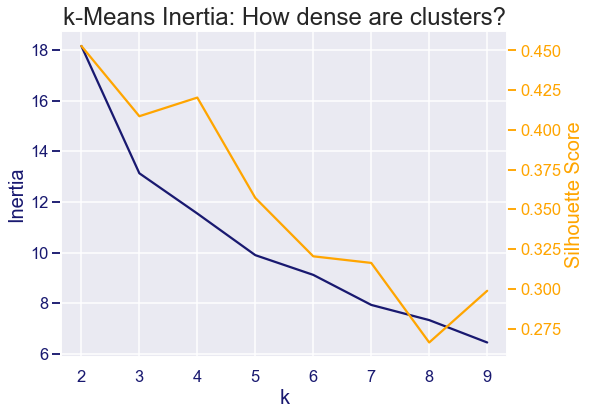

In [24]:
chooseK(co2_toCluster)

$k=3$ has a much higher silhouette score than $k=4$. It doesn't have as dense of clusters though. Let's look at both options.

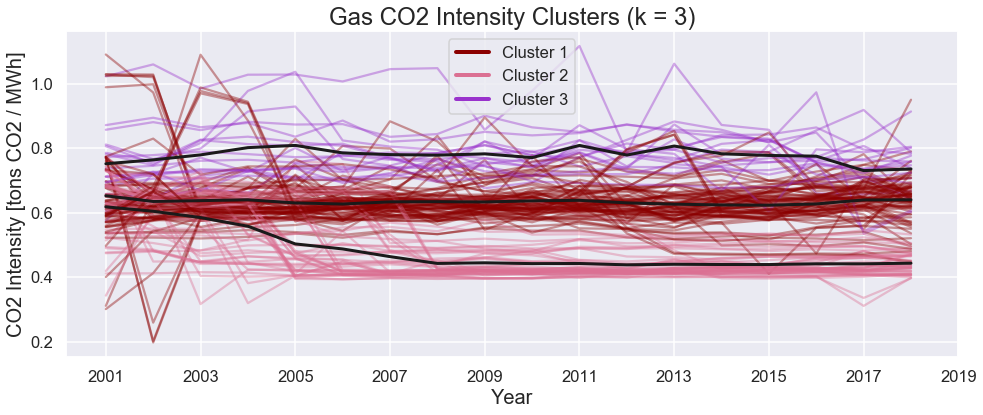

In [53]:
k_means_gas_k3 = fitKMeans(co2_toCluster, 3)
plotKMeans(k_means_gas_k3, co2_toCluster, 'Gas')

In [59]:
co2_toCluster['cluster_3'] = k_means_gas_k3.labels_

C:\Users\austi\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [71]:
co2_toCluster[co2_toCluster['cluster_3'] == 2]

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,cluster_3
330,0.575553,0.721351,0.770580,0.725971,0.800713,0.729055,0.774896,0.784835,0.808409,0.778480,0.770455,0.825738,0.882597,0.856768,0.817998,0.848231,0.695806,0.707242,2
342,0.737435,0.745461,0.760849,0.764087,0.755028,0.778617,0.763962,0.759211,0.676019,0.693829,0.773081,0.814412,0.795498,0.840583,0.842101,0.864150,0.795554,0.782704,2
354,1.022368,1.059276,0.984200,1.027401,1.027831,1.006466,1.044646,1.047629,0.857195,0.977253,1.116340,0.787568,1.061403,0.871856,0.856823,0.659560,0.656891,0.666642,2
489,0.806142,0.751955,0.816139,0.977254,1.036455,0.823836,0.804825,0.795304,0.743770,0.714405,0.824601,0.743627,0.827214,0.767335,0.756566,0.761447,0.806872,0.737675,2
492,0.811263,0.766408,0.798849,0.913387,0.928939,0.766359,0.745920,0.782854,0.769173,0.755606,0.787582,0.736402,0.873378,0.780321,0.788594,0.855091,0.918305,0.787078,2
720,0.658269,0.644100,0.714258,0.728373,0.701000,0.787644,0.767423,0.766041,0.782858,0.790340,0.743443,0.774988,0.754099,0.795572,0.787034,0.718788,0.711474,0.641739,2
723,0.605193,0.641418,0.674592,0.662151,0.751321,0.742167,0.743418,0.699890,0.750396,0.767625,0.870980,0.796825,0.782403,0.667473,0.810223,0.686947,0.711353,0.690821,2
891,0.781661,0.746945,0.825004,0.812602,0.808043,0.813743,0.771420,0.726182,0.821211,0.746560,0.794967,0.782558,0.801696,0.834269,0.825992,0.758217,0.765786,0.800836,2
894,0.785718,0.759390,0.826279,0.835527,0.818923,0.807623,0.768570,0.731637,0.757436,0.742485,0.804917,0.782548,0.762219,0.813326,0.825027,0.755830,0.722250,0.776689,2
921,0.682264,0.705714,0.706725,0.714864,0.711306,0.707161,0.718737,0.695871,0.708418,0.716234,0.728672,0.742149,0.740890,0.730826,0.732040,0.753453,0.736546,0.757550,2


In [64]:
CO2I_gas.loc[330, :]  # peaker used very infreuqently

ORISPL_CODE                        118
UNITID                             CT3
NAME           APS Saguaro Power Plant
FUEL                                NG
GAS                                CO2
2001                          0.575553
2002                          0.721351
2003                           0.77058
2004                          0.725971
2005                          0.800713
2006                          0.729055
2007                          0.774896
2008                          0.784835
2009                          0.808409
2010                           0.77848
2011                          0.770455
2012                          0.825738
2013                          0.882597
2014                          0.856768
2015                          0.817998
2016                          0.848231
2017                          0.695806
2018                          0.707242
Name: 330, dtype: object

In [72]:
CO2I_gas.loc[942, :]  # peaker used very infreuqently

ORISPL_CODE        3456
UNITID              **4
NAME             Newman
FUEL                 NG
GAS                 CO2
2001           0.856987
2002           0.880539
2003           0.855808
2004           0.881783
2005           0.873124
2006           0.874404
2007            0.83511
2008           0.843675
2009           0.900555
2010           0.864478
2011           0.850031
2012           0.872399
2013           0.856947
2014           0.849323
2015           0.818174
2016           0.972785
2017           0.534843
2018           0.601849
Name: 942, dtype: object

In [74]:
CO2I_gas.loc[723, :]  # peaker used very infreuqently

ORISPL_CODE                               404
UNITID                                      2
NAME           Scattergood Generating Station
FUEL                                       NG
GAS                                       CO2
2001                                 0.605193
2002                                 0.641418
2003                                 0.674592
2004                                 0.662151
2005                                 0.751321
2006                                 0.742167
2007                                 0.743418
2008                                  0.69989
2009                                 0.750396
2010                                 0.767625
2011                                  0.87098
2012                                 0.796825
2013                                 0.782403
2014                                 0.667473
2015                                 0.810223
2016                                 0.686947
2017                              

In [67]:
CO2I_gas.loc[315, :]  # CCGT used at CF = 0.8

ORISPL_CODE                             117
UNITID                                  CC4
NAME           APS West Phoenix Power Plant
FUEL                                     NG
GAS                                     CO2
2001                               0.474781
2002                                0.47972
2003                               0.483489
2004                               0.516867
2005                               0.760413
2006                               0.750939
2007                                0.50619
2008                               0.513169
2009                               0.519856
2010                               0.512151
2011                                0.51834
2012                               0.522882
2013                               0.514819
2014                               0.517731
2015                                0.50991
2016                               0.494909
2017                               0.493419
2018                            

In [69]:
CO2I_gas.loc[312, :]  # Ocotillo - used medium amount

ORISPL_CODE                     116
UNITID                            2
NAME           Ocotillo Power Plant
FUEL                             NG
GAS                             CO2
2001                       0.620404
2002                       0.658447
2003                       0.665174
2004                       0.625278
2005                       0.668851
2006                       0.661172
2007                       0.667873
2008                        0.75035
2009                       0.703249
2010                       0.732647
2011                       0.724911
2012                       0.736383
2013                       0.715047
2014                       0.762688
2015                       0.698397
2016                       0.727578
2017                       0.748639
2018                       0.790039
Name: 312, dtype: object

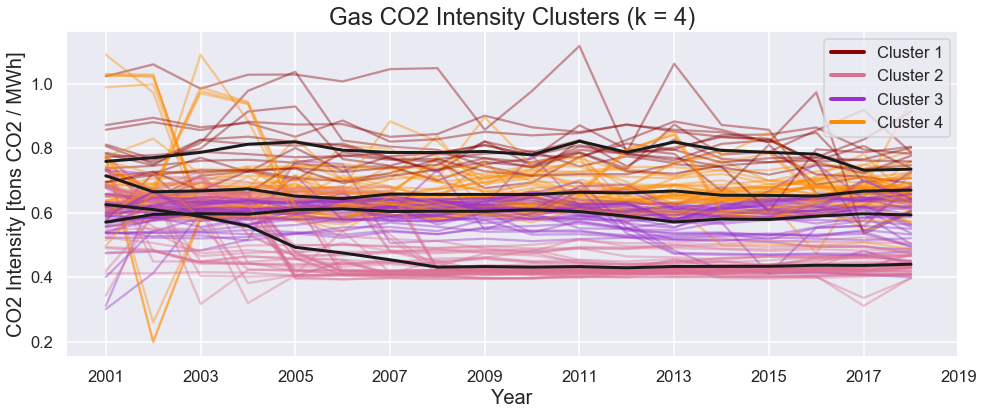

In [26]:
k_means_gas = fitKMeans(co2_toCluster, 4)
plotKMeans(k_means_gas, co2_toCluster, 'Gas')

Clusters are being distressingly dragged upward by a few anomalies. Gonna need to drop a few rows. (Edit: done)

Note that 3 clusters makes a whole lot of sense here. There are three types of tech lumped into the 'gas' category: CCGT, CT, and CHP (cogen)--I do need to check which plants are included though.

It looks like the most efficient plants went through a major change in 2005.

I also need to come up with a way to include the missing data (Edit: do I?).

Coal

In [27]:
co2_coal_full = CO2I_coal.dropna().iloc[:, endOfMetadata:]
# topOutlier = np.argmax(co2_coal_full['2001'].values)  # max in 2001. One line sits far above the others and takes up a cluster.
# topOutlier
# CO2I_coal.dropna().iloc[36, :]  # probably non-physical. Tiny coal plant in Montana. Drop.
# co2_coal_full.drop(195, axis=0, inplace=True)

Interpolate

In [28]:
CO2I_coal_interp = CO2I_coal.interpolate(method='spline', order=3, axis=0, limit=3, limit_area='inside')
CO2I_coal_interp_full = CO2I_coal_interp.dropna().iloc[:, endOfMetadata:]

Filter outliers

In [29]:
co2_coal_toCluster = CO2I_coal_interp_full[((CO2I_coal_interp_full < 1.3)&(CO2I_coal_interp_full > 0.8)).all('columns')]

How many units are we dropping at various stages?

In [30]:
print('Units after splitting up CO2: ', CO2I_coal.shape)
print('Units left after dropping any row with a NaN: ', co2_coal_full.shape)
print('Units left after interp, then dropping any row with a NaN: ', CO2I_coal_interp_full.shape)
print('Then filter for 0.8 < CO2I < 1.3: ', co2_coal_toCluster.shape)

Units after splitting up CO2:  (89, 23)
Units left after dropping any row with a NaN:  (59, 18)
Units left after interp, then dropping any row with a NaN:  (79, 18)
Then filter for 0.8 < CO2I < 1.3:  (70, 18)


Choosing k

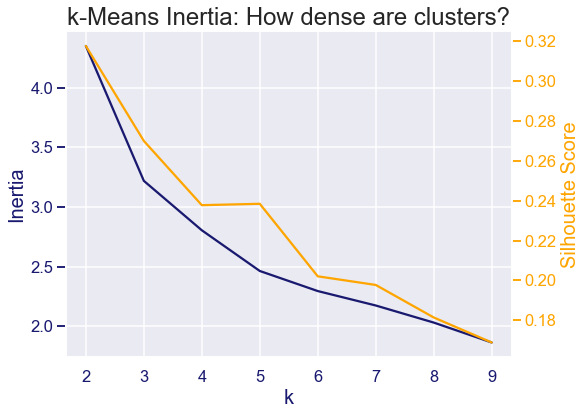

In [31]:
chooseK(co2_coal_toCluster)

Looks like $k=3$ or $k=4$ would serve us well. There is a slight elbow at 3 for inertia. Low inertia is good, but too many clusters compared to the units begins to get unreasonable. Also, the silhouette score is much higher for 4 than 5, which is good. Silhouette score is a measure of the distance from a point in a cluster to its neighbors.

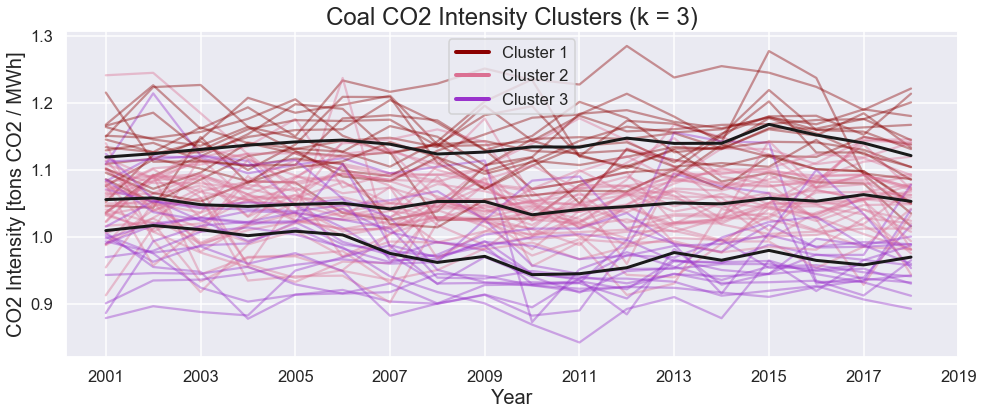

In [32]:
k_means_coal = fitKMeans(co2_coal_toCluster, 3)
plotKMeans(k_means_coal, co2_coal_toCluster, 'Coal')

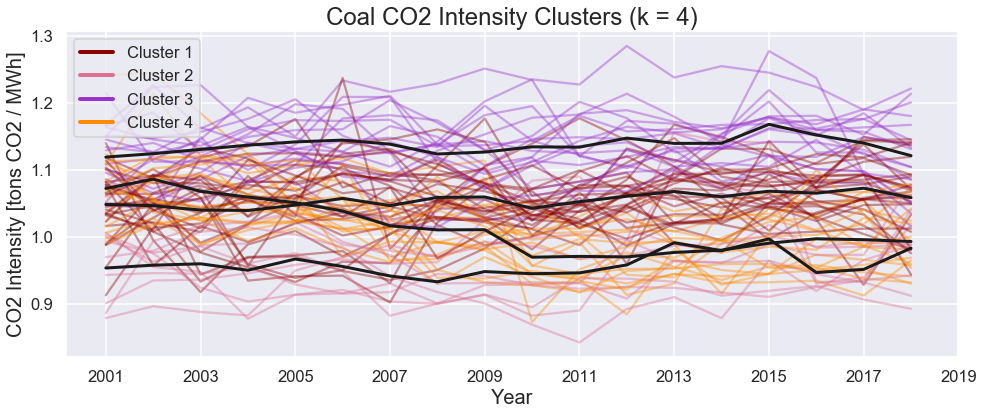

In [33]:
k_means_coal = fitKMeans(co2_coal_toCluster, 4)
plotKMeans(k_means_coal, co2_coal_toCluster, 'Coal')

Separate clusters to see if groups of plants are actually increasing/decreasing.

EDIT: With the outlier removed, some significant differences start to emerge. The highest cluster may be showing a very slight increase. The 2nd from the top is roughly steady. The bottom two flip-flop, indicating some plants are operating less efficiently or changed to a higher intensity fuel source, and some plants did just the opposite.

Unfortunately, we can really see the effect of the outlier taking over the 4th cluster here. We'll have to add one more, or remove it and refit.

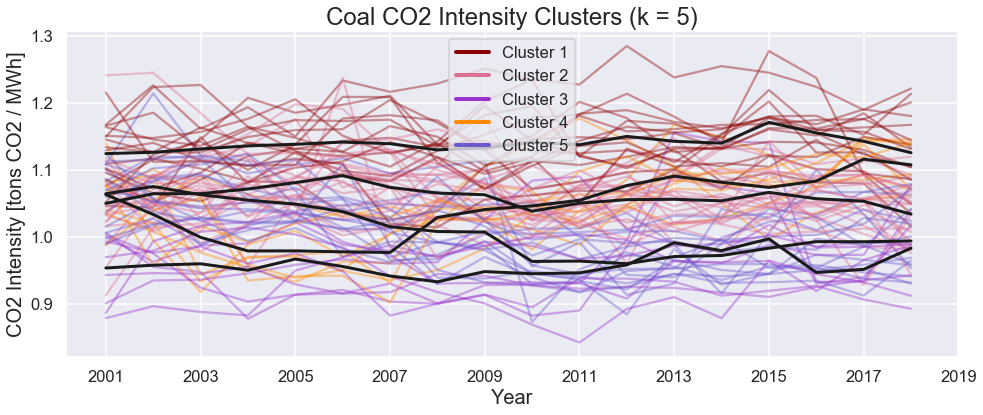

In [34]:
k_means_coal = fitKMeans(co2_coal_toCluster, 5)
plotKMeans(k_means_coal, co2_coal_toCluster, 'Coal')

EDIT: Now a different outlier has overtaken the 5th cluster. We can stick mostly to 4.

We're really trying to focus on trend here. Is the centroid showing an increase or decrease? Note that these will be relatively slight increases. From this plot, it looks like the clusters that start at $1.0$ and $1.17$ $\frac{tons \thinspace{} CO2}{MWh}$ show a slight increase. The cluster that starts 3rd from the bottom (or top) decreases substantially.

In [35]:
k_means_coal.labels_

array([3, 1, 0, 3, 1, 0, 4, 1, 4, 1, 0, 0, 1, 0, 1, 0, 1, 2, 2, 3, 3, 3, 3,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 4, 4, 1, 1, 2, 0, 0, 1, 1, 0, 4, 4,
       4, 2, 3, 3, 0, 1, 0, 0, 4, 4, 4, 4, 1, 4, 4, 2, 2, 1, 2, 2, 4, 4, 2,
       1])

#### Clustering on (most) available data

In [36]:
def filterForBothHavles(df, thresh):
    # Ensure both halves of time series have substantial data to allow for before/after comparison
    # Thresh = max NaNs in either half of the data
    copy = df.copy()
    for ind, row in copy.iterrows():
        H1 = row[endOfMetadata:endOfMetadata+9]
        H2 = row[endOfMetadata+9:]
        if sum(H1.isnull()) > thresh or sum(H2.isnull()) > thresh:
            copy.drop(ind, axis=0, inplace=True)
    print(copy.shape)
    return copy

Investigate how much data we cut at each threshold step

In [37]:
for i in range(3, 10):
    print("If it can't have more than", i, "NaNs in either half:")
    data = filterForBothHavles(CO2I_gas, i)

If it can't have more than 3 NaNs in either half:
(290, 23)
If it can't have more than 4 NaNs in either half:
(317, 23)
If it can't have more than 5 NaNs in either half:
(350, 23)
If it can't have more than 6 NaNs in either half:
(373, 23)
If it can't have more than 7 NaNs in either half:
(419, 23)
If it can't have more than 8 NaNs in either half:
(448, 23)
If it can't have more than 9 NaNs in either half:
(485, 23)


In [38]:
for i in range(3, 10):
    print("If it can't have more than", i, "NaNs in either half:")
    data = filterForBothHavles(CO2I_coal, i)

If it can't have more than 3 NaNs in either half:
(74, 23)
If it can't have more than 4 NaNs in either half:
(77, 23)
If it can't have more than 5 NaNs in either half:
(84, 23)
If it can't have more than 6 NaNs in either half:
(85, 23)
If it can't have more than 7 NaNs in either half:
(86, 23)
If it can't have more than 8 NaNs in either half:
(88, 23)
If it can't have more than 9 NaNs in either half:
(89, 23)


Interpolate values with splines when we have valid values on either side. Interpolates up to 3 consecutive years. Often this type of missing data is present in peaker plants, when there was no operation over that period.

In [39]:
import pandas as pd
pd.__version__

'0.24.1'

In [40]:
CO2I_gas = CO2I_gas.interpolate(method='spline', order=3, axis=0, limit=3, limit_area='inside')

In [41]:
CO2I_coal = CO2I_coal.interpolate(method='spline', order=3, axis=0, limit=3, limit_area='inside')

In [42]:
for i in range(3, 10):
    print("If it can't have more than", i, "NaNs in either half:")
    data = filterForBothHavles(CO2I_gas, i)

If it can't have more than 3 NaNs in either half:
(361, 23)
If it can't have more than 4 NaNs in either half:
(393, 23)
If it can't have more than 5 NaNs in either half:
(403, 23)
If it can't have more than 6 NaNs in either half:
(420, 23)
If it can't have more than 7 NaNs in either half:
(450, 23)
If it can't have more than 8 NaNs in either half:
(460, 23)
If it can't have more than 9 NaNs in either half:
(485, 23)


In [43]:
for i in range(3, 10):
    print("If it can't have more than", i, "NaNs in either half:")
    data = filterForBothHavles(CO2I_coal, i)

If it can't have more than 3 NaNs in either half:
(86, 23)
If it can't have more than 4 NaNs in either half:
(86, 23)
If it can't have more than 5 NaNs in either half:
(89, 23)
If it can't have more than 6 NaNs in either half:
(89, 23)
If it can't have more than 7 NaNs in either half:
(89, 23)
If it can't have more than 8 NaNs in either half:
(89, 23)
If it can't have more than 9 NaNs in either half:
(89, 23)


In [45]:
fuel = 'Coal'
thresh = 3
CO2I_coal = filterForBothHavles(CO2I_coal, thresh)
SO2I_coal = filterForBothHavles(SO2I_coal, thresh)
NOXI_coal = filterForBothHavles(NOXI_coal, thresh)
# plotEI_heatmap(CO2I_coal, SO2I_coal, NOXI_coal, fuel)

(86, 23)
(74, 23)
(74, 23)


Since we've kept 85 of the 89 units in this data by interpolating, let's drop the incomplete rows and cluster on what we have.

In [46]:
co2_coal_full = CO2I_coal.dropna().shape

In [47]:
k_means_coal = fitKMeans(co2_coal_full, 3)
plotKMeans(k_means_coal, co2_coal_full, 'Coal')

ValueError: Expected 2D array, got 1D array instead:
array=[ 79.  23.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [48]:
k_means_coal = fitKMeans(co2_coal_full, 4)
plotKMeans(k_means_coal, co2_coal_full, 'Coal')

ValueError: Expected 2D array, got 1D array instead:
array=[ 79.  23.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

Gas

For gas, filter out plants for which there is no substantial portion of (2001-09) or (2010-2018). We can't meaningfully use these to determine the difference between the low and high variance periods.

##### Weight clustering with MWh generation

Weighted by the sum of generation

In [49]:
def chooseK_wtd(X, weights):
    # X = data to cluster [observations x variables]
    inertia = []
    silho = []
    K = range(2, 10)
    for k in K:
        model = fitKMeans_wtd(X, weights, k)
        inertia.append(model.inertia_)
        silho.append(silhouette_score(X, model.labels_))

    fig, ax1 = plt.subplots(figsize=(8, 6))
    sns.lineplot(K, inertia, color='midnightblue', ax=ax1)
    ax1.set_ylabel('Inertia', color='midnightblue')
    ax1.tick_params(colors='midnightblue')
    ax1.set_xlabel('k', color='midnightblue')

    ax2 = ax1.twinx()
    sns.lineplot(K, silho, color='orange', ax=ax2)
    ax2.set_ylabel('Silhouette Score', color='orange')
    ax2.tick_params(colors='orange')

    plt.grid(False)
    plt.title('Weighted k-Means Inertia: How dense are clusters?')
    plt.show()

Choosing k

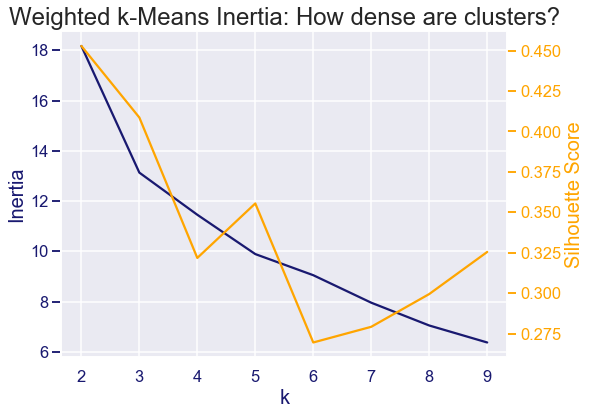

In [50]:
weights = gasGen_byUnit
chooseK_wtd(co2_toCluster, weights)

$k = 4$ looks like the best choice here.

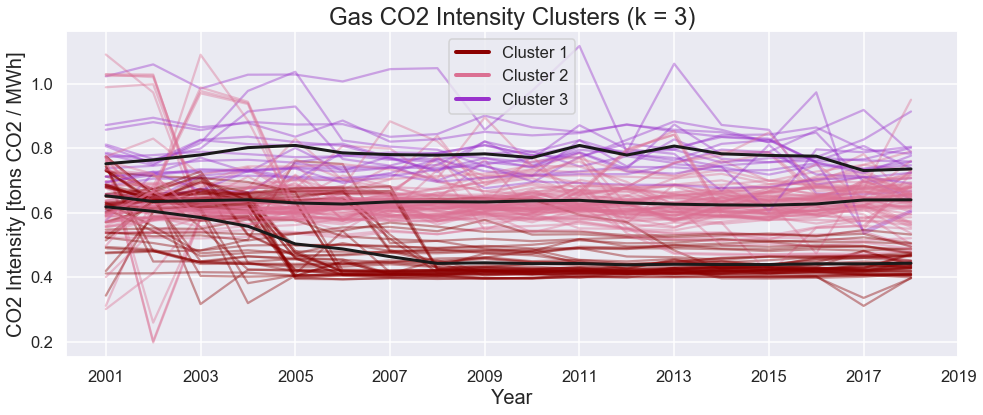

In [51]:
weights = gasGen_byUnit
k_means_gas = fitKMeans_wtd(co2_toCluster, weights, 3)  
plotKMeans(k_means_gas, co2_toCluster, 'Gas')

Coal